# Process preedited 4T1 10x data

**Author:** William Colgan <br>
**Date:** June 18 2024 <br>
**Enviromnent:** py10-env <br>

## Purpose

This notebook processes 10x scRNA-seq data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublet and low quality cells. It also processes target site reads, filtering out alleles with insufficient coverage, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [395]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import treedata as td
from sklearn.decomposition import NMF
from pathlib import Path
import sys

Configure paths

In [396]:
base_path = Path("/lab/solexa_weissman/PEtracing_shared/PETracer_Paper/")
data_path = base_path / "preedited" / "data"
reference_path = base_path / "reference"
sys.path.append(str(base_path))
plt.style.use(base_path / 'plot.mplstyle')

Load helper functions

In [ ]:
from src.config import colors, sequential_cmap, site_names
from src.ts_utils import bimodal_cutoff, call_clones, select_allele
site_names = list(site_names.keys())

Configure plotting

In [ ]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors[1:])

## Load data

Specify samples and names

In [398]:
samples = {"4T1_preedited":"4T1_preedited"}

Transciptome

In [399]:
adata = []
for sample, name in samples.items():
    adata_sample = sc.read_10x_h5(data_path / sample / f"{sample}_filtered_counts.h5")   
    adata_sample.var_names_make_unique()  
    adata.append(adata_sample)
adata = ad.concat(adata, join='outer',label = "sample", keys = list(samples.values()))  
adata.obs["cellBC"] = (adata.obs["sample"].astype(str) + "-" + adata.obs.index)  
adata.obs.index = adata.obs["cellBC"].values          

/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Target site

In [400]:
alleles = []
for sample, name in samples.items():
    sample_alleles = pd.read_csv(data_path / sample / f"{sample}_allele_counts.csv",keep_default_na=False)
    sample_alleles["sample"] = name
    sample_alleles["cellBC"] = (name + "-" + sample_alleles["cellBC"])
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(adata.obs.index)]

## Sequencing statistics

In [401]:
adata.var['TS'] = adata.var.index.str.startswith('intID')
adata.var['GEX'] = ~adata.var['TS']
adata.var['MT'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT',"TS","GEX"], percent_top=None, log1p=False, inplace=True)

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

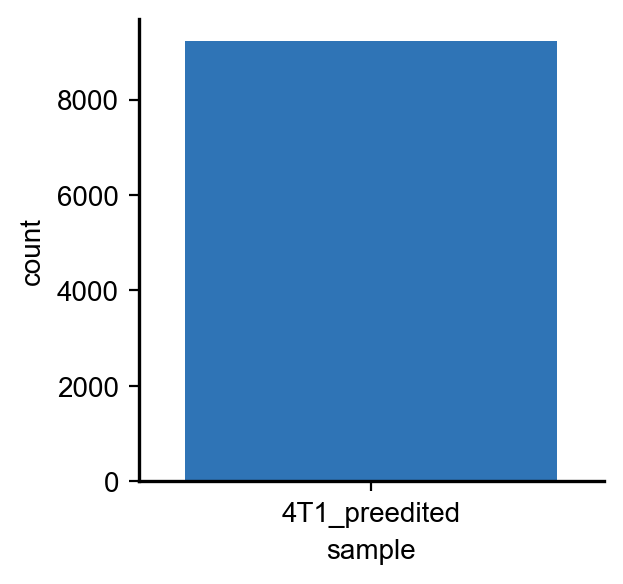

In [402]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

UMIs per cell per sample

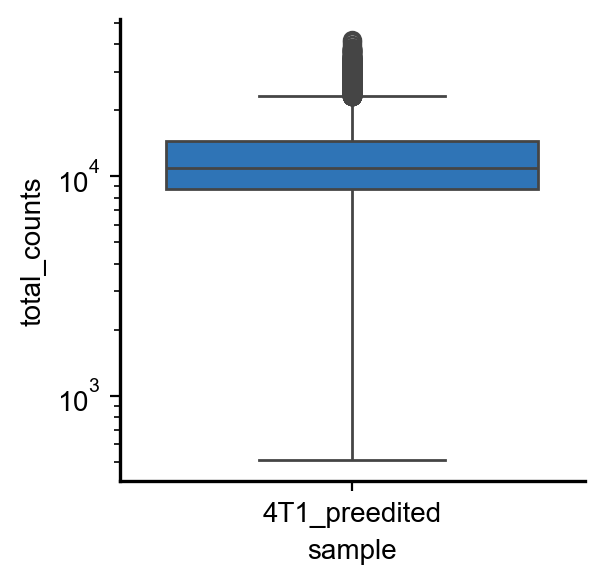

In [403]:
sns.boxplot(data = adata.obs, x = "sample", y = "total_counts",hue = "sample",legend=False,saturation = 1)
plt.yscale("log")

GEX UMIs vs TS UMIs per sample

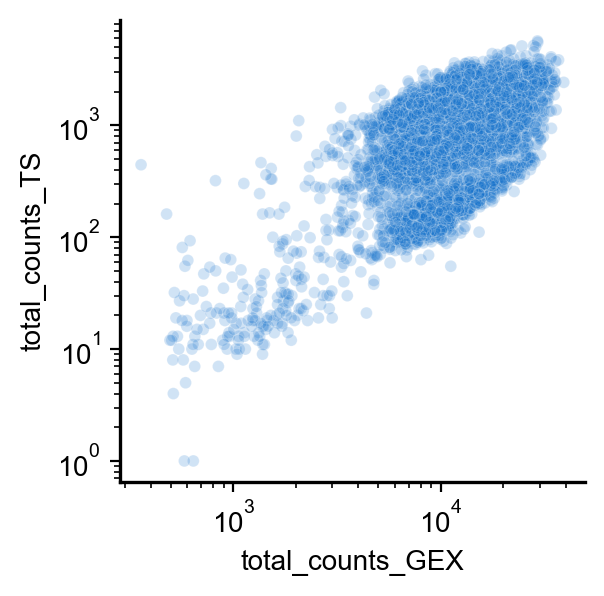

In [404]:
sns.scatterplot(data = adata.obs, x = "total_counts_GEX", y = "total_counts_TS",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.yscale("log")

## Low quality cells

In [405]:
adata.obs["type"] = "normal"
adata.obs["pct_counts_MT"] = adata.obs["total_counts_MT"]/adata.obs["total_counts_GEX"]*100

Cells with high mitochondrial content

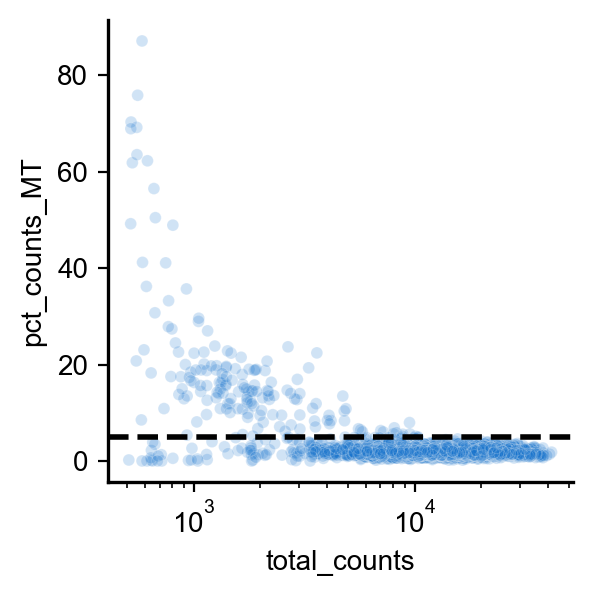

In [406]:
max_mt_pct = 5
adata.obs.loc[adata.obs["pct_counts_MT"] > max_mt_pct, "type"] = "high_mito"
sns.scatterplot(data = adata.obs, x = "total_counts", y = "pct_counts_MT",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.axhline(y=max_mt_pct, color="black", linestyle="--")

Cells with too few UMIs

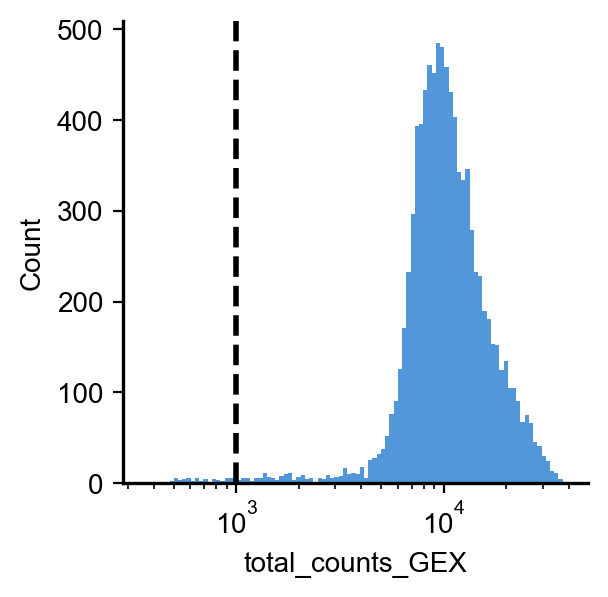

In [407]:
min_gex = 1000
adata.obs.loc[adata.obs["total_counts_GEX"] < min_gex, "type"] = "low_umi"
sns.histplot(data = adata.obs, x = "total_counts_GEX", hue = "sample", bins = 100, log_scale = True,
              legend=False, multiple="stack",linewidth=0)
plt.axvline(x=min_gex, color="black", linestyle="--")

Cell types

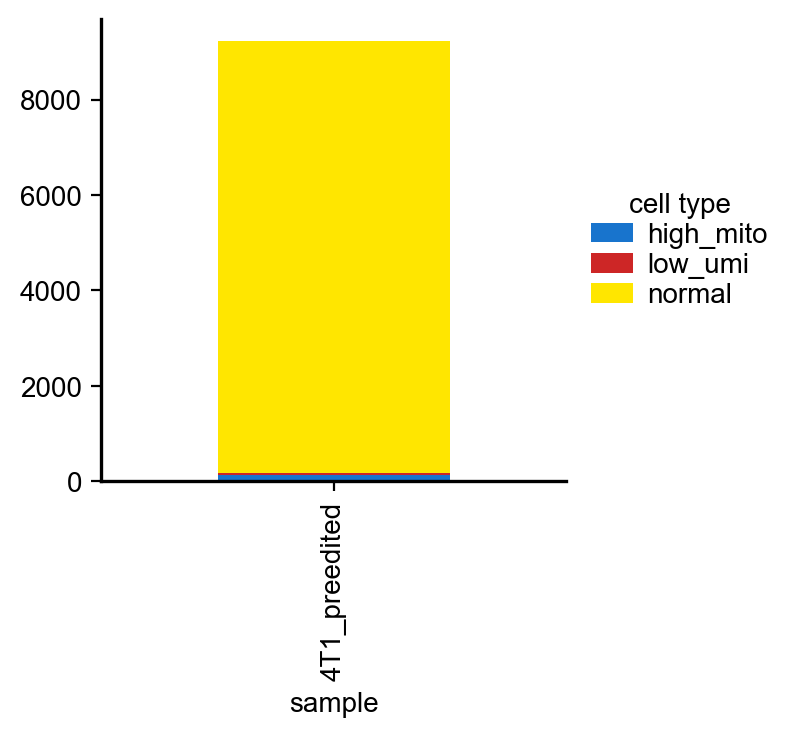

In [408]:
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter target site reads

In [409]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = alleles.query("cellBC.isin(@normal_cells) & UMI > 1").copy()
filtered_alleles["keep"] = True

Set minimum number of reads per UMI

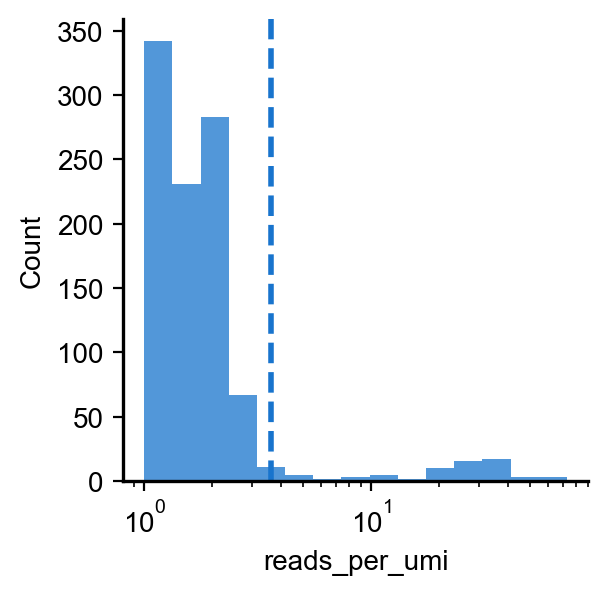

In [410]:
sample_colors = {sample:color for sample, color in zip(sorted(samples.values()),colors[1:])}
filtered_alleles["reads_per_umi"] = filtered_alleles["readCount"]/filtered_alleles["UMI"]
sns.histplot(data = filtered_alleles.sample(10000), x = "reads_per_umi", bins = 10, 
             log_scale = True, hue = "sample", multiple="dodge",linewidth=0,palette=sample_colors)
for sample, sample_alleles in filtered_alleles.groupby("sample"):
    cutoff = bimodal_cutoff(sample_alleles["reads_per_umi"])
    filtered_alleles.loc[(filtered_alleles["sample"] == sample) & (filtered_alleles["reads_per_umi"] < cutoff),"keep"] = False
    plt.axvline(x=cutoff, linestyle="--",color = sample_colors[sample])

Set minimum number of UMIs per target site for each sample

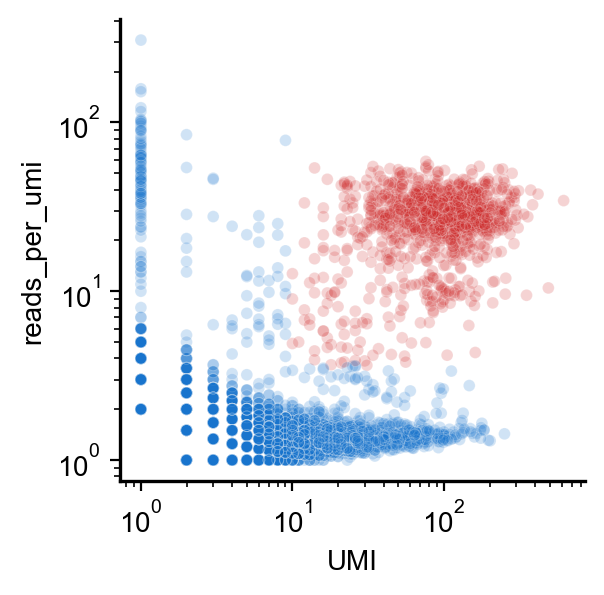

In [411]:
for sample, sample_alleles in filtered_alleles.query("keep").copy().groupby("sample"):
    for integration, int_alleles in sample_alleles.groupby("intID"):
        cutoff = bimodal_cutoff(int_alleles["UMI"])
        filtered_alleles.loc[(filtered_alleles["sample"] == sample) & (filtered_alleles["UMI"] < cutoff), "keep"] = False
sns.scatterplot(data = filtered_alleles.sample(10000), x = "UMI", y = "reads_per_umi",
                hue = "keep",size = .1,alpha = .2,legend=False)
plt.yscale("log")
plt.xscale("log")

In [412]:
filtered_alleles = filtered_alleles.query("keep").drop(columns="keep").copy()

## Identify clones

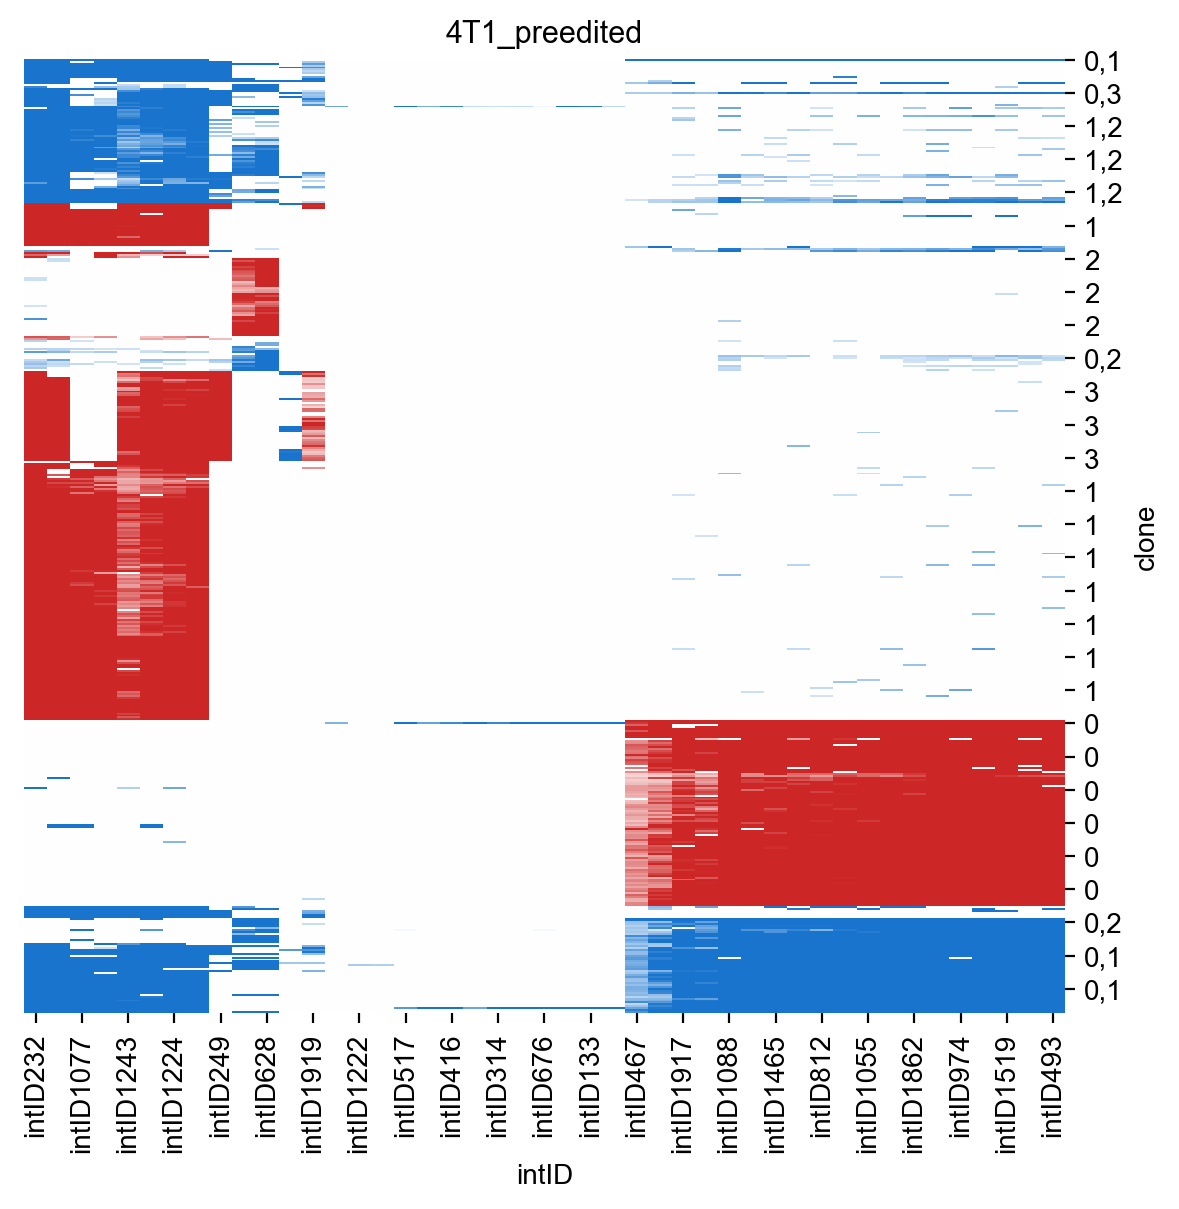

In [413]:
sample_n_clones =  {"4T1_preedited":4}
whitelist_alleles = []
for sample, n_clones in sample_n_clones.items():
    model = NMF(n_components=n_clones)
    whitelist_alleles.append(call_clones(filtered_alleles.query("sample == @sample"),model,plot_title = sample))
whitelist_alleles = pd.concat(whitelist_alleles)

Rename clones by size

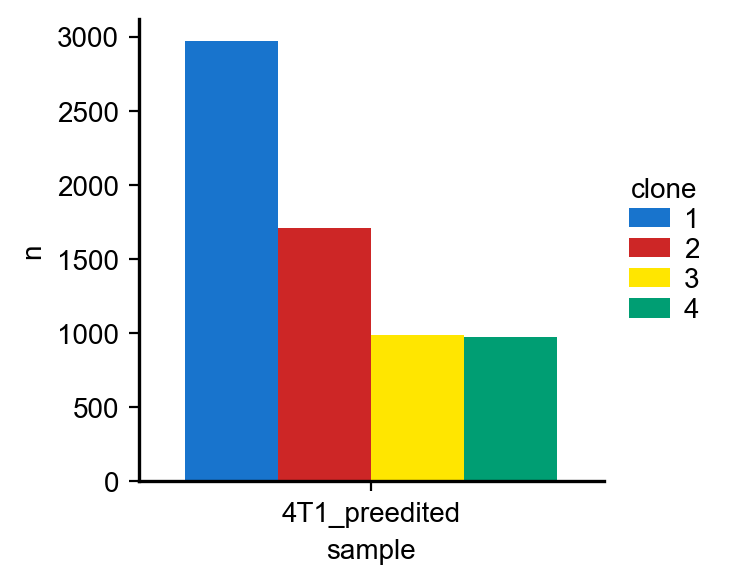

In [426]:
cell_to_clone = whitelist_alleles.query("whitelist").groupby(["cellBC","sample"])["clone"].first().reset_index()
clone_counts = cell_to_clone.groupby(["sample","clone"]).size().reset_index(name = "n").sort_values("n",ascending = False)
clone_counts["new"] = (clone_counts.reset_index().index + 1).astype(str)
sns.barplot(data = clone_counts,x = "sample", y = "n",hue = "new",saturation = 1,multiple="stack")
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))

Add clone to cells and alleles

In [415]:
cell_to_clone = cell_to_clone.merge(clone_counts[["sample","clone","new"]], 
        on = ["sample","clone"]).drop(columns = "clone").rename(columns = {"new":"clone"})
filtered_alleles = whitelist_alleles
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["clone"])
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["clone"])

Mark doublets

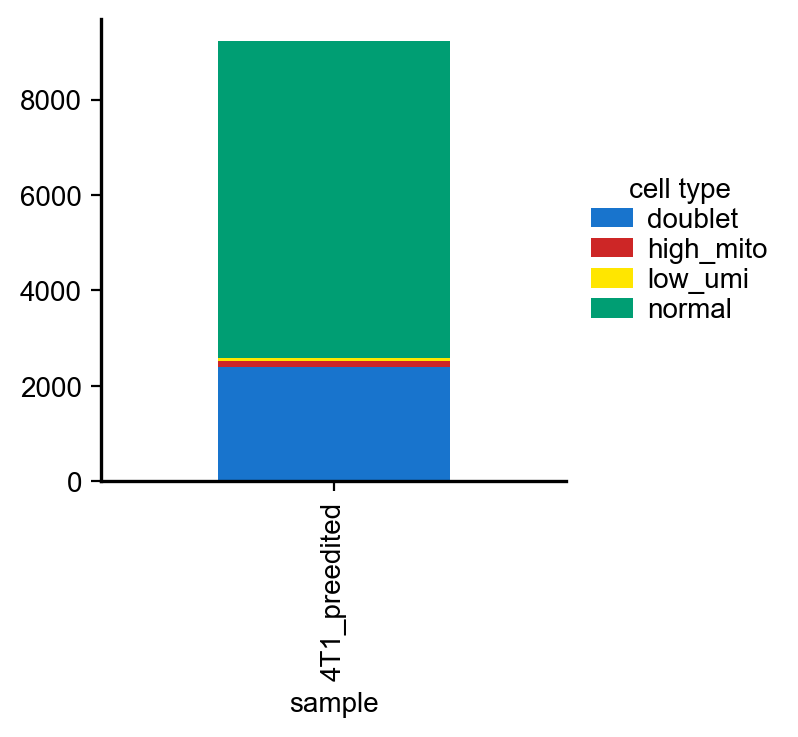

In [416]:
adata.obs.loc[(adata.obs.type == "normal") & (adata.obs.clone.isna()), "type"] = "doublet"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter alleles

In [417]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

Remove alleles with < 20% of UMIs in a cell

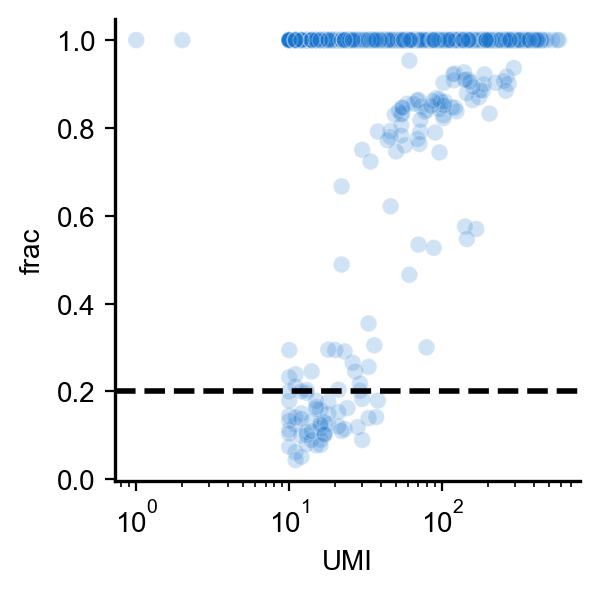

In [421]:
min_umi_frac = .2
filtered_alleles["frac"] = filtered_alleles["UMI"] / filtered_alleles.groupby(["cellBC", "intID"])["UMI"].transform("sum")
sns.scatterplot(filtered_alleles.sample(10000), x = "UMI",y = "frac",alpha = .2,size = .1)
plt.xscale("log")
plt.axhline(y=min_umi_frac, color="black", linestyle="--")
filtered_alleles = filtered_alleles.query("frac > @min_umi_frac").copy()

Select allele with the most edits as long as the alleles differ by at most one edit

In [ ]:
filtered_alleles["n_alleles"] = filtered_alleles.groupby(['intID', 'cellBC'])["intID"].transform("count")
selected_alleles = filtered_alleles[filtered_alleles.n_alleles == 2].groupby(['intID', 'cellBC']).apply(select_allele).reset_index(drop = True)
filtered_alleles = pd.concat([filtered_alleles[filtered_alleles.n_alleles != 2],selected_alleles])

Remove integrations with conflicts in >20% of UMIs

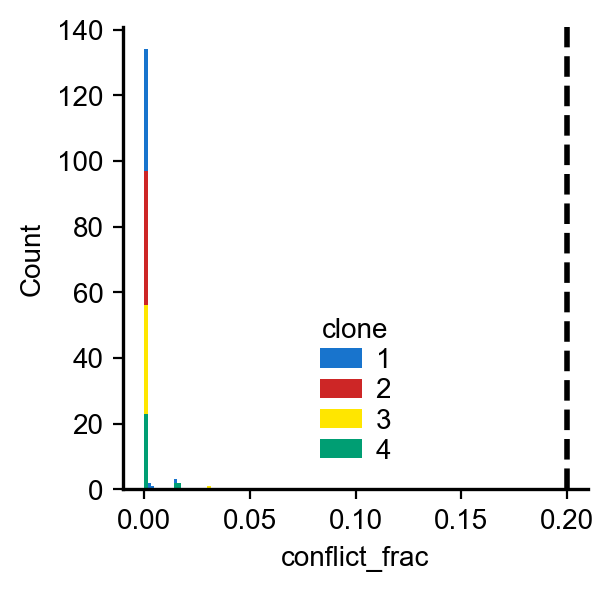

In [433]:
max_int_conflict = .2
int_conflicts = filtered_alleles[filtered_alleles.n_alleles > 1].groupby(["clone","intID"])["UMI"].sum() / filtered_alleles.groupby(["clone","intID"])["UMI"].sum()
int_conflicts = int_conflicts.reset_index().fillna(0).rename(columns = {"UMI":"conflict_frac"})
filtered_alleles = filtered_alleles.merge(int_conflicts, on = ["clone","intID"]).query(
    "conflict_frac < @max_int_conflict ").copy().drop(columns = "conflict_frac")
sns.histplot(int_conflicts, x = "conflict_frac",bins = 20,hue = "clone",multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_int_conflict, color="black", linestyle="--")

Mark cells with conflicts in >20% of integration UMIs as doublets

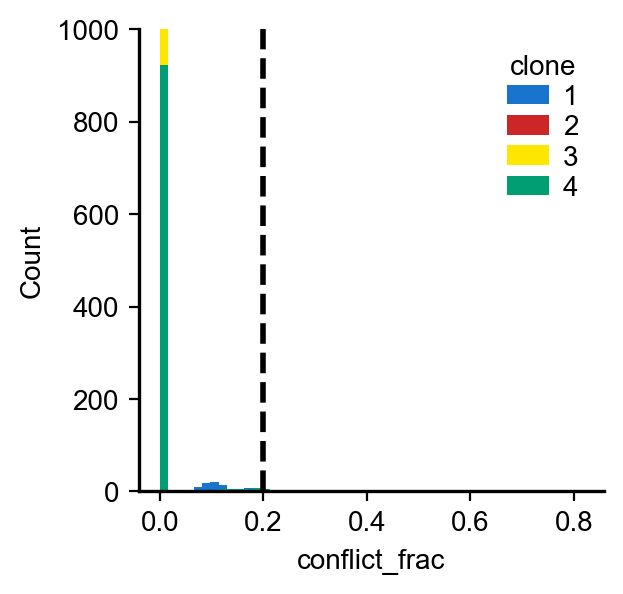

In [434]:
max_cell_conflict = .2
cell_conflicts = filtered_alleles[filtered_alleles.n_alleles > 1].groupby(["cellBC","clone"])["UMI"].sum() / filtered_alleles.groupby(["cellBC","clone"])["UMI"].sum()
cell_conflicts = cell_conflicts.reset_index().fillna(0).rename(columns = {"UMI":"conflict_frac"})
sns.histplot(cell_conflicts, x = "conflict_frac",bins = 50,hue = "clone",multiple = "stack",linewidth=0,alpha = 1)
plt.ylim(0,1000)
plt.axvline(x=max_cell_conflict, color="black", linestyle="--")
doublets = cell_conflicts.query("conflict_frac > @max_cell_conflict")["cellBC"]

Resolve remaining conflict by selecting allele with most UMIs

In [435]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("frac",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["frac","n_alleles"])

Mark doublets

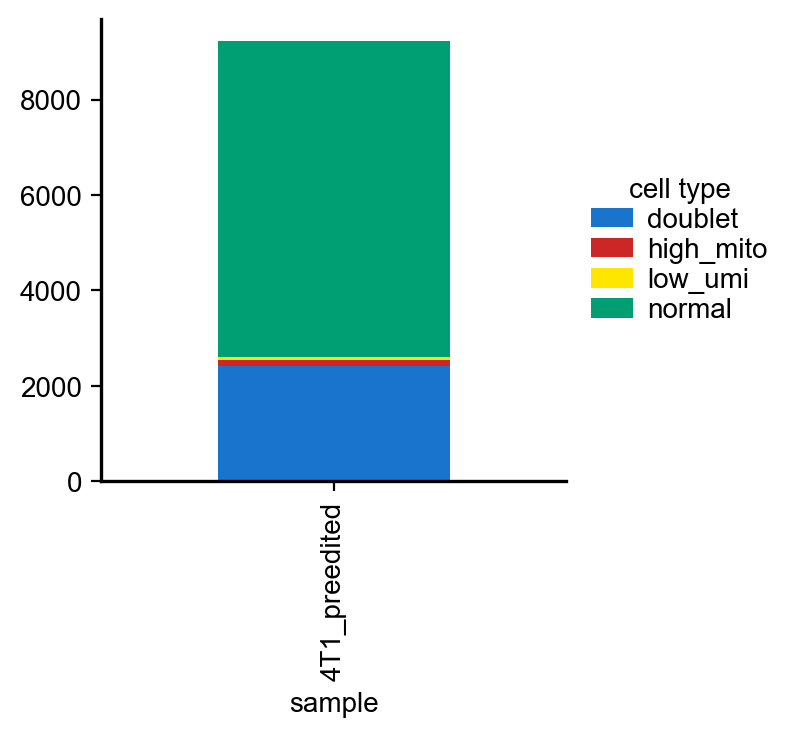

In [436]:
adata.obs.loc[(adata.obs.type == "normal") & (adata.obs.cellBC.isin(doublets)), "type"] = "doublet"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

Detection rate

<Axes: xlabel='clone', ylabel='detection_rate'>

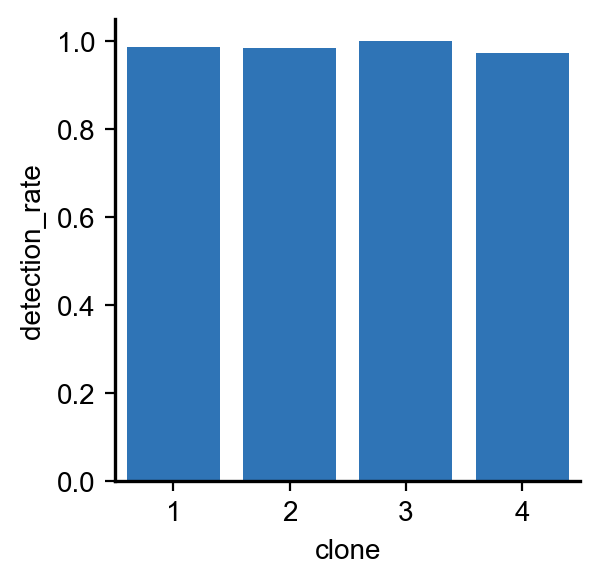

In [438]:
int_detection = (filtered_alleles.query("whitelist").groupby(["intID","clone","sample"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["cellBC"].nunique())
int_detection = int_detection.reset_index(name = "detection_rate")
sns.barplot(data = int_detection.groupby(["clone"]).agg({"detection_rate":"mean"}).reset_index(),y = "detection_rate",x = "clone")

Detection rate per integration

<Axes: xlabel='clone', ylabel='intID'>

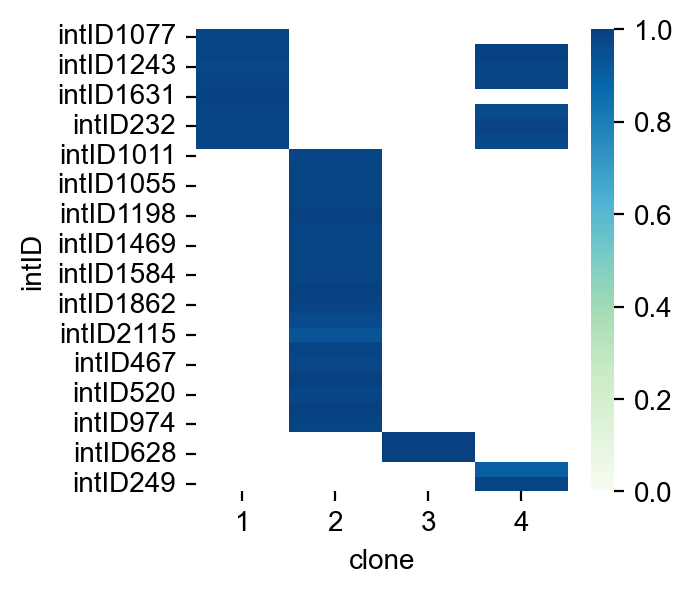

In [441]:
int_order = int_detection.intID.drop_duplicates()
int_detection_wide = pd.pivot_table(int_detection,columns=["clone"], index=["intID"], values="detection_rate")
sns.heatmap(int_detection_wide.loc[int_order,:],cmap = sequential_cmap,vmin = 0)

Edit fraction

<Axes: xlabel='clone', ylabel='edit_frac'>

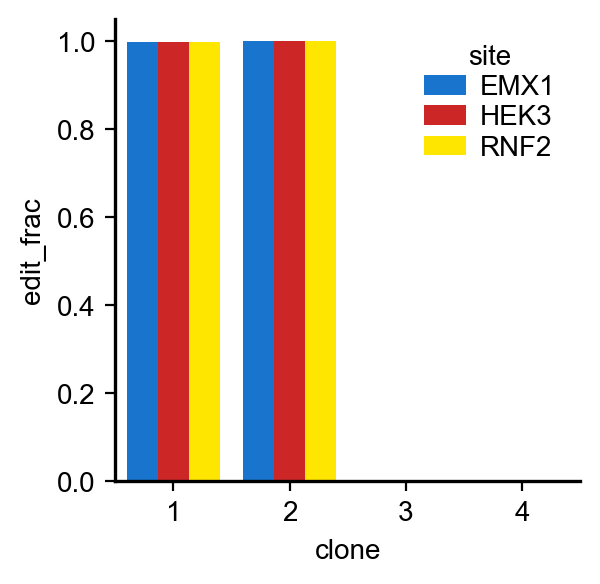

In [446]:
edit_counts = filtered_alleles.query("whitelist")[site_names + ['UMI',"cellBC","intID","clone","sample"]].melt(
    id_vars = ["cellBC","UMI","intID","clone","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["clone","sample","intID","site"]).size()/ \
    edit_counts.groupby(["clone","sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["clone","site"]).agg({"edit_frac":"mean"}).reset_index()
sns.barplot(data = edit_frac,y = "edit_frac",x = "clone",hue = "site",saturation=1)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))

Edit frequency

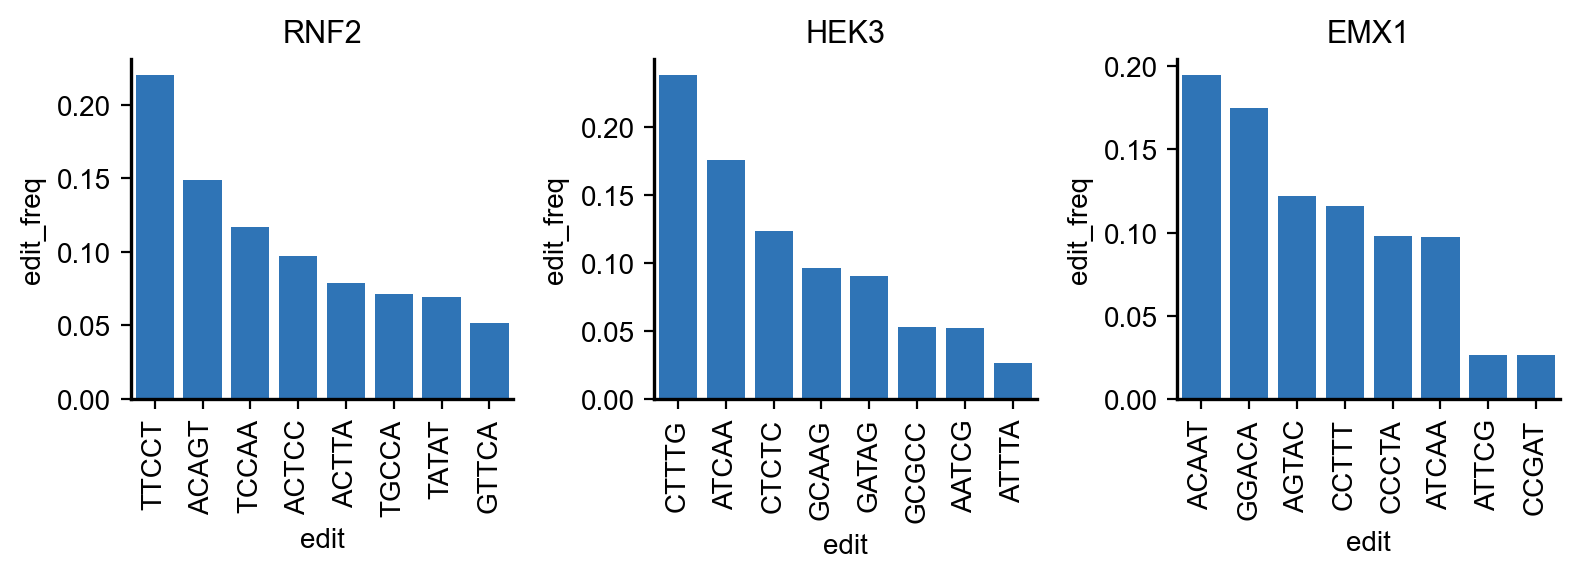

In [451]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(15),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout()

## Barcode mapping

Setup

In [454]:
from src.seq_utils import correct_to_whitelist

ImportError: cannot import name 'correct_to_whitelist' from 'src.seq_utils' (/lab/solexa_weissman/PEtracing_shared/PETracer_Paper/src/seq_utils.py)

Load data

In [455]:
mapping = []
for sample, name in samples.items():
    sample_mapping = pd.read_csv(data_path / sample / f"{sample}_mapping_counts.csv",keep_default_na=False)
    sample_mapping["sample"] = name
    sample_mapping["cellBC"] = (name + "-" + sample_mapping["cellBC"])
    mapping.append(sample_mapping)
mapping = pd.concat(mapping)

In [456]:
mapping

,intID,cellBC,intBC,UMI,readCount,sample
0,intID14,4T1_preedited-ACTCTCGGTCTTCGAA-1,CTGATCAGCCTCGACTGTGCCT,1,5,4T1_preedited
1,intID14,4T1_preedited-CAATCGAAGTACCGGA-1,CTGATCAGCCTCGACTGTGCCTTCTAGTTG,1,4,4T1_preedited
2,intID14,4T1_preedited-CCACACTCATCTCCCA-1,CTGNTCAGCCTCGACTGTGCCN,1,5,4T1_preedited
3,intID14,4T1_preedited-CCTCATGCATGTACGT-1,CTGATCAGCCTCGACTGTGCCT,1,5,4T1_preedited
4,intID14,4T1_preedited-CGGGCATAGTTCCATG-1,CTGATCAGCCACGCCTGTGCCT,1,4,4T1_preedited
...,...,...,...,...,...,...
1997081,intID2129,4T1_preedited-TTTGTTGTCCTAGCTC-1,ACCTGTCTTGTCATTGTAGGTGGTACAATG,1,4,4T1_preedited
1997082,intID2129,4T1_preedited-TTTGTTGTCCTAGCTC-1,ACCTGTCTTGTCTTTGGAGGTTGTACAAGG,1,4,4T1_preedited
1997083,intID2129,4T1_preedited-TTTGTTGTCCTAGCTC-1,TCCTCTCTTGTCATTGGAGGTTGTACAATG,1,20,4T1_preedited
1997084,intID2129,4T1_preedited-TTTGTTGTCCTAGCTC-1,TCCTCTCTTGTCCTTGGAGGTTGTACAATG,1,10,4T1_preedited


In [447]:
normal_cells = adata.obs.loc[adata.obs["type"] == "normal","cellBC"]
filtered_mapping = mapping[(mapping["cellBC"].isin(normal_cells)) & (mapping.UMI >= 2)].copy()
filtered_mapping = filtered_mapping.merge(cell_to_clone[["cellBC","clone"]],on = "cellBC",how = "left")

Correct to whitelist

In [448]:
filtered_mapping["intBC"] = correct_to_whitelist(filtered_mapping.intBC,whitelist.intBC,2)
filtered_mapping = filtered_mapping.groupby(["cellBC", "intID","intBC","sample","clone"]).agg({"UMI":"sum","readCount":"sum"}).reset_index()
filtered_mapping = filtered_mapping[filtered_mapping["intBC"].str.len() == 30]

Remove mapping with < 20% of UMIs in a cell

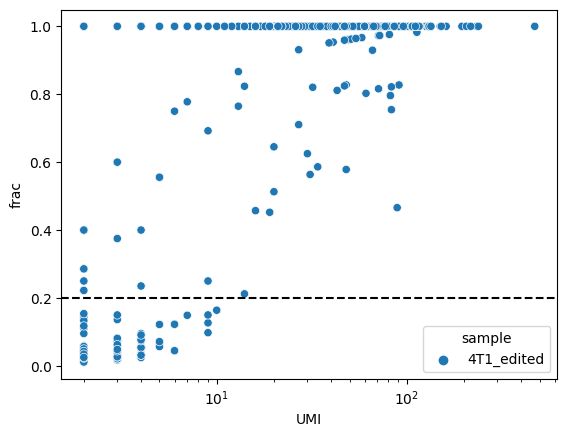

In [449]:
min_umi_frac = .2
filtered_mapping["frac"] = filtered_mapping["UMI"] / filtered_mapping.groupby(["cellBC", "intID"])["UMI"].transform("sum")
sns.scatterplot(filtered_mapping.sample(1000), x = "UMI",y = "frac",hue = "sample")
plt.xscale("log")
plt.axhline(y=min_umi_frac, color="black", linestyle="--")
filtered_mapping = filtered_mapping.query("frac > .2 & readCount > 200").copy()

In [450]:
filtered_mapping = filtered_mapping.sort_values("frac",ascending = False).groupby(["cellBC","intID"]).first().reset_index()
filtered_mapping["n_cells_mapping"] = filtered_mapping.groupby(["clone","intID"])["cellBC"].transform("size")
filtered_mapping = filtered_mapping.rename(columns = {"intID":"mfID"}).merge(whitelist[["intID","intBC"]],on = "intBC",how = "left")

<Axes: xlabel='intID', ylabel='mfID'>

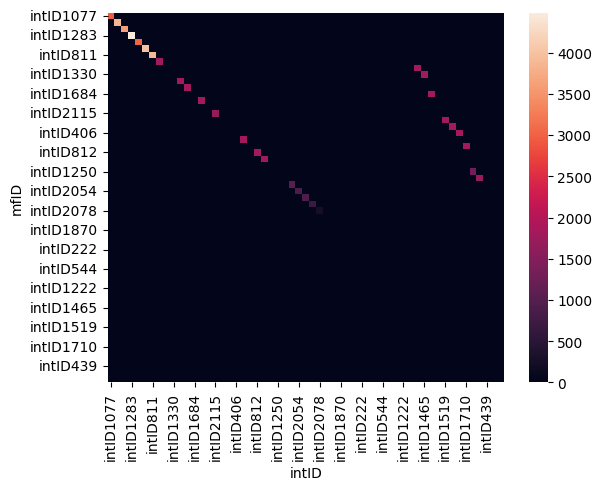

In [451]:
unique_values = pd.unique(filtered_mapping[['mfID', 'intID']].values.ravel('K'))
whitelist_counts = pd.pivot_table(filtered_mapping, index=["mfID"], columns="intID", values="cellBC", aggfunc="count")
whitelist_counts = whitelist_counts.reindex(index=unique_values, columns=unique_values, fill_value=0).fillna(0)
sns.heatmap(whitelist_counts)

In [455]:
mapping_whitelist = filtered_mapping.drop_duplicates(["clone","intID"])[["clone","intID","mfID","n_cells_mapping"]]
allele_whitelist = filtered_alleles.query("whitelist").groupby(["clone","intID","RNF2","HEK3","EMX1"]).size().sort_values(
    ascending = False).reset_index(name = "n_cells").groupby(["clone","intID"]).first().reset_index()
allele_whitelist = allele_whitelist.merge(mapping_whitelist,on = ["intID","clone"],how = "outer")
allele_whitelist = pd.concat([allele_whitelist,mapping_whitelist[~mapping_whitelist.mfID.isin(allele_whitelist.mfID)]])
allele_whitelist = allele_whitelist.query("~n_cells.isna() | n_cells_mapping > 500")
allele_whitelist["type"] = "normal"
allele_whitelist.loc[allele_whitelist.intID != allele_whitelist.mfID,"type"] = "swap"
allele_whitelist.loc[allele_whitelist.intID.isna(),"type"] = "intBC_mutation"
allele_whitelist.loc[allele_whitelist.type == "intBC_mutation","intID"] = allele_whitelist.loc[allele_whitelist.type == "intBC_mutation","mfID"]
allele_whitelist.loc[allele_whitelist.mfID.isna(),"type"] = "mfBC_mutation"
allele_whitelist.loc[allele_whitelist.type == "mfBC_mutation","mfID"] = allele_whitelist.loc[allele_whitelist.type == "mfBC_mutation","intID"]

<Axes: xlabel='n_cells', ylabel='n_cells_mapping'>

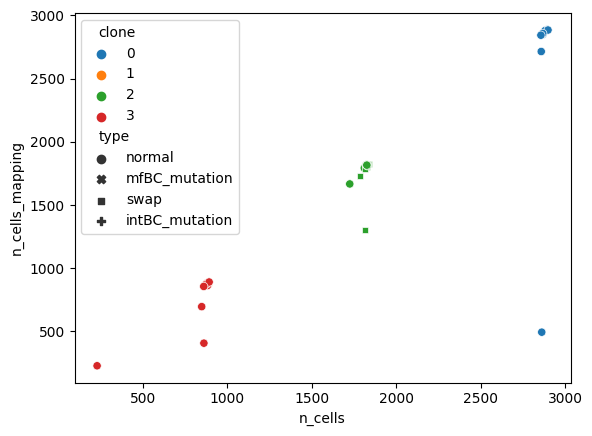

In [456]:
sns.scatterplot(data = allele_whitelist,x = "n_cells",y = "n_cells_mapping",hue = "clone",style = "type")

## Write results

In [464]:
out_path = "/lab/solexa_weissman/PEtracing_shared/PETracer_Analysis/4T1_fully_edited/"
adata.obs = adata.obs[['sample', 'cellBC', 'type', 'clone']].copy()
# cell meta data
adata.obs.to_csv(f"{out_path}data/231219_4T1_edited_cell_meta.tsv",sep="\t",index=False)
# write sc_data
adata.write_h5ad(f"{out_path}data/231219_4T1_edited.h5ad")
# mapping data
filtered_mapping.to_csv(f"{out_path}data/231219_4T1_edited_mapping.tsv",sep="\t")
# allele data
filtered_alleles.to_csv(f"{out_path}data/231219_4T1_edited_alleles.tsv",sep="\t")
# whitelist
allele_whitelist.to_csv(f"{out_path}results/4T1_edited_allele_whitelist.csv",sep="\t")